In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from plot_sklearn_dendrogram import plot_sklearn_dendrogram # local python file to view dendrogram
from scipy import stats
from math import floor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
import graphviz

Our data are separated into different datasets, as we didn't imported the data all at once. 
- For the clustering we will use information on four variables for each country : The government health expenditures (% of GNI), the Water use (pers), the life expectancy (years) and the natural ressources rents (% of GNI)
- For the classification we will add : The surface area (m²), the population and the GNI (US dollar), CO2 emissions (metric tons per capita), Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%), Number of under-five deaths, People using at least basic drinking water services (% of population), Suicide mortality rate (per 100,000 population) and Immunization, measles (% of children ages 12-23 months)

# Import data

### GNI | Surface | Population dataset

In [3]:
dfgni = pd.read_csv("GNI_Surface_Data.txt",sep="\t",header=0)
dfgni = dfgni.dropna()

In [4]:
dfgni.head()

,Time,Time Code,Country Name,Country Code,Surface,Population,GNI
0,2010,YR2010,Afghanistan,AFG,652860.0,28803167,1.599880e+10
1,2010,YR2010,Bangladesh,BGD,148460.0,152149102,1.246171e+11
2,2010,YR2010,Bhutan,BTN,38394.0,727641,1.497492e+09
3,2010,YR2010,India,IND,3287260.0,1230980691,1.638663e+12
4,2010,YR2010,Maldives,MDV,300.0,364511,2.276923e+09


In [5]:
len(dfgni)

193

After removing all rows with missing values, we have 193 countries left, which is enough to complete our analysis.

### clustering dataset

We will use this dataset for the clustering.

In [6]:
dfautres = pd.read_csv("autres_Data.txt",sep="\t",header=0)
dfautres=dfautres.drop(columns=["Food Deficit"])

In [7]:
dfautres = dfautres.dropna()

In [8]:
dfautres.head()

,Time,Time Code,Country Name,Country Code,Gvnt_health_exp,Life expectancy,Nat_resources_rents
0,2010,YR2010,Afghanistan,AFG,2.255471,61.226,0.732845
1,2010,YR2010,Bangladesh,BGD,4.071213,70.198,1.309144
2,2010,YR2010,Bhutan,BTN,6.477769,67.790,5.155270
3,2010,YR2010,India,IND,3.169405,66.625,4.671042
4,2010,YR2010,Maldives,MDV,13.603584,76.112,0.008966


### additional data for classification 

In [9]:
classification2 = pd.read_csv("additional_Data.txt",sep="\t",header=0)

In [10]:
classification2 = classification2.dropna()

In [11]:
classification2.head()

,Time,Time Code,Country Name,Country Code,CO2 emissions,Mortality_diseases,under_five_deaths,Water_use,Suicide_rate,measles_immunization
0,2010,YR2010,Afghanistan,AFG,0.293837,31.7,101383.0,50.046191,5.1,62.0
1,2010,YR2010,Albania,ALB,1.578574,18.6,423.0,88.089492,7.8,99.0
2,2010,YR2010,Algeria,DZA,3.299704,15.4,23676.0,92.388330,3.3,95.0
5,2010,YR2010,Angola,AGO,1.243406,18.1,122844.0,40.057690,5.7,67.0
6,2010,YR2010,Antigua and Barbuda,ATG,5.539568,21.6,16.0,97.088704,0.3,98.0


In [12]:
len(classification2)

182

There are enough coutries to complete our classification dataset.

# Merge datasets

We now merge the three datasets (dfgni, dfautres, classification2) according to the country code, in order to obtain a full dataset to use for the classification.

In [13]:
data = pd.merge(dfgni, dfautres, how='inner', on=['Country Name', 'Country Code'])

In [14]:
data=data.drop(columns=['Time_x', 'Time Code_x', 'Time_y', 'Time Code_y'])

In [15]:
dataComplet = pd.merge(data, classification2, how='inner', on=['Country Name', 'Country Code'])

In [16]:
dataComplet=dataComplet.drop(columns=['Time','Time Code' ])

In [17]:
dataComplet.loc[:,'under_five_deaths']=dataComplet.loc[:,'under_five_deaths']/(dataComplet.loc[:,'Population']//10000)

Since the number of deaths of infants (<5yo) is given directly for each country, we decided to convert it : it will now indicate the number of infant deaths for 10,000 inhabitants

In [18]:
# set index with country code
data = data.set_index('Country Code')
dataComplet = dataComplet.set_index('Country Code')

In [19]:
len(dataComplet)

173

In [20]:
dfautres=dataComplet.loc[:,["Life expectancy","Water_use","Gvnt_health_exp","Nat_resources_rents"]]
len(dfautres)

173

There are enough coutries left. dataComplet dataset will be used for classification, and for clustering we reduced the number of variables to 4 (dfautres).

# Boxplots visualization

We will now use a normalisation of our data column by column, so we can visualize and detect outliers

### clustering dataset (dfautres)

In [21]:
# set index with country code
dfautresn = dfautres

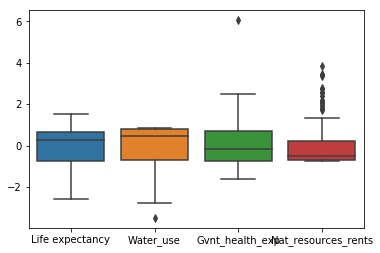

In [22]:
# boxplot of the clustering data
Z_scored_dfautres = (dfautresn-dfautresn.mean())/dfautresn.std()
sns.boxplot(data=Z_scored_dfautres)

### classification dataset (dataComplet)

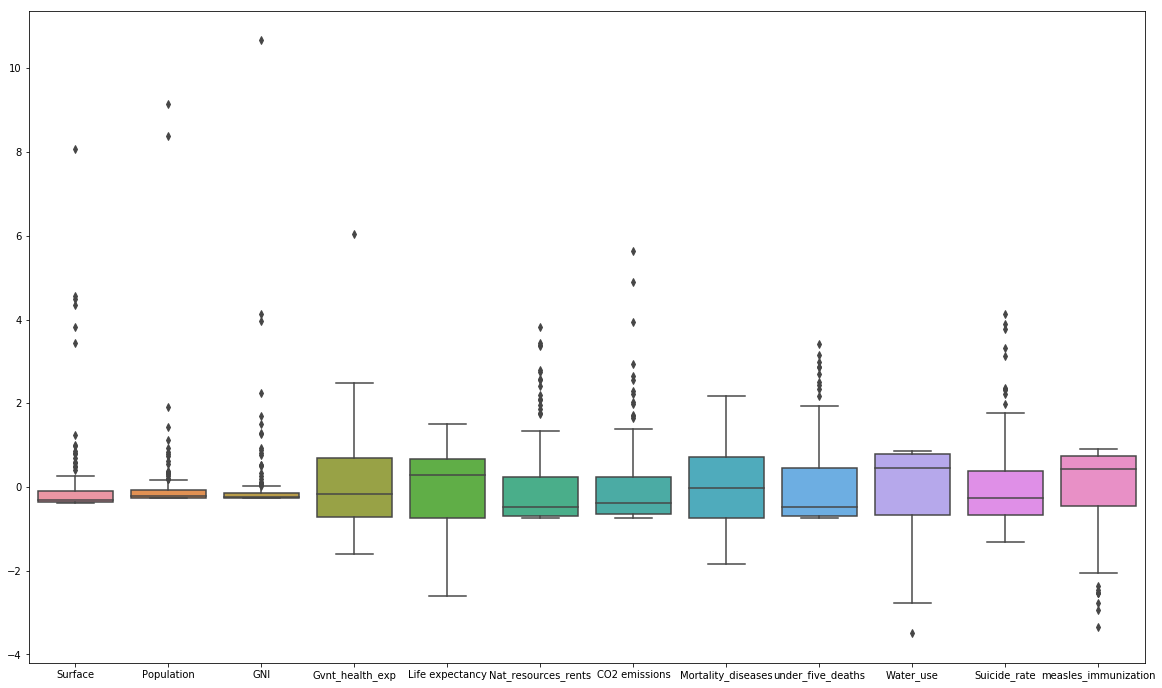

In [23]:
# boxplot with the whole dataset (classification)
plt.figure(figsize=(20,12))
datan = dataComplet.iloc[:,1:]
Z_scored_df = (datan-datan.mean())/datan.std()
sns.boxplot(data=Z_scored_df)

# Outliers detection

As we could previously see, some values seem to be out of range, and might have an influence on our future classification and clusters. We defined a threshold, so that all values above it should be considered as an outlier and removed from the dataset.

## dfautres

In [24]:
dfautresn.mean(axis=0) # mean for each variable

Life expectancy        69.864656
Water_use              83.973652
Gvnt_health_exp         9.562510
Nat_resources_rents     8.753988
dtype: float64

In [25]:
threshold = 2.5
mask = np.abs(dfautresn) > dfautresn.mean()+threshold*dfautresn.std()
outliers = dfautresn[mask.any(axis=1)]

In [26]:
mask.any()

Life expectancy        False
Water_use              False
Gvnt_health_exp         True
Nat_resources_rents     True
dtype: bool

In [27]:
mask.loc[sorted(list(set(outliers.index)))]

,Life expectancy,Water_use,Gvnt_health_exp,Nat_resources_rents
Country Code,,,,
AGO,False,False,False,True
BLZ,False,False,True,False
COG,False,False,False,True
IRQ,False,False,False,True
KWT,False,False,False,True
LBY,False,False,False,True
MNG,False,False,False,True
MRT,False,False,False,True
SAU,False,False,False,True


The previous countries are considered as outliers, according to our threshold, but different variables are impacted. Since we would like to keep the oil-producing countries in our analysis, we decided to ignore outliers that are only related to this variable. As to the remaining country, we decided to remove it, so our final dataset contains 172 countries.

In [28]:
maskbis=mask.iloc[:,:3]
outliersbis = dfautresn[maskbis.any(axis=1)]

In [29]:
dfautrestri = dfautresn.loc[sorted(list(set(dfautresn.index).difference(set(outliersbis.index))))]

In [30]:
len(dfautrestri)

172

Even after removing the outliers, we have enough countries left to run our analysis.

## dataComplet

We repeat the same procedure on the dataset used for classification

In [31]:
datan.mean(axis=0) # mean for each variable

Surface                 7.603908e+05
Population              3.869789e+07
GNI                     3.668762e+11
Gvnt_health_exp         9.562510e+00
Life expectancy         6.986466e+01
Nat_resources_rents     8.753988e+00
CO2 emissions           4.720955e+00
Mortality_diseases      2.018439e+01
under_five_deaths       1.232659e+01
Water_use               8.397365e+01
Suicide_rate            9.916763e+00
measles_immunization    8.770520e+01
dtype: float64

In [32]:
threshold = 2.5
mask2 = np.abs(datan) > datan.mean()+threshold*datan.std()
outliers2 = datan[mask2.any(axis=1)]

In [33]:
mask2.any()

Surface                  True
Population               True
GNI                      True
Gvnt_health_exp          True
Life expectancy         False
Nat_resources_rents      True
CO2 emissions            True
Mortality_diseases      False
under_five_deaths        True
Water_use               False
Suicide_rate             True
measles_immunization    False
dtype: bool

As we previously did, we ignore the outliers related to natural ressources rent

In [34]:
mask2bis=mask2.drop(columns=["Nat_resources_rents"])
outliers2bis = datan[mask2bis.any(axis=1)]
len(mask2bis.loc[sorted(list(set(outliers2bis.index)))])

26

We found 26 outliers, but among them some countries just had a really large surface and/or population (USA,RUS,IND ...). Hence, we decided to calculate Density instead of keeping Surface and Population, and divided GNI by the population, so that it is expressed as a ratio of the total population.

In [35]:
# Density calculation
datanbis=datan.copy(deep=True)
Density=datanbis.iloc[:,1]/datanbis.iloc[:,0]
datanbis.iloc[:,2]=datanbis.iloc[:,2]/datanbis.iloc[:,1]
datanbis=datanbis.drop(columns="Population")

In [36]:
# add Density to the dataset
datanbis.iloc[:,0]=Density
datanbis=datanbis.rename({"Surface":"Density"}, axis='columns')
len(datanbis)

173

In [37]:
# outliers detection
threshold = 2.5
mask3 = np.abs(datanbis) > datanbis.mean()+threshold*datanbis.std()
outliers3 = datanbis[mask3.any(axis=1)]
# we keep outliers not related to nat. ressources
mask3=mask3.drop(columns=["Nat_resources_rents"])
outliers3 = datanbis[mask3.any(axis=1)]

In [38]:
len(mask3.loc[sorted(list(set(outliers3.index)))])

23

As there are less outliers with transformed data, we decided use this dataset instead of the former.

In [39]:
datatri = datanbis.loc[sorted(list(set(datanbis.index).difference(set(outliers3.index))))]

In [40]:
len(datatri)

150

There are enough countries left to run our classification.

# Correlation



## clustering dataset

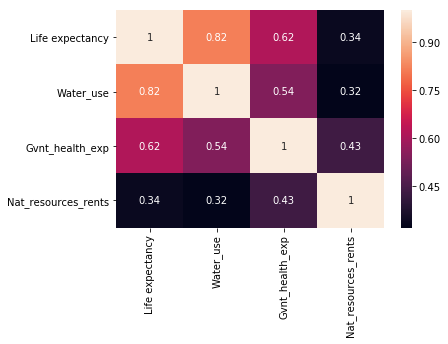

In [41]:
sns.heatmap(abs(dfautrestri.corr()),annot=True)

We can see that the Life expectancy values are correlated both to the water use values and to the Government health expenditure values. From that first test, we can say that countries with a higher water use and with higher health expenditures tend to have a higher life expectancy.

## classification dataset

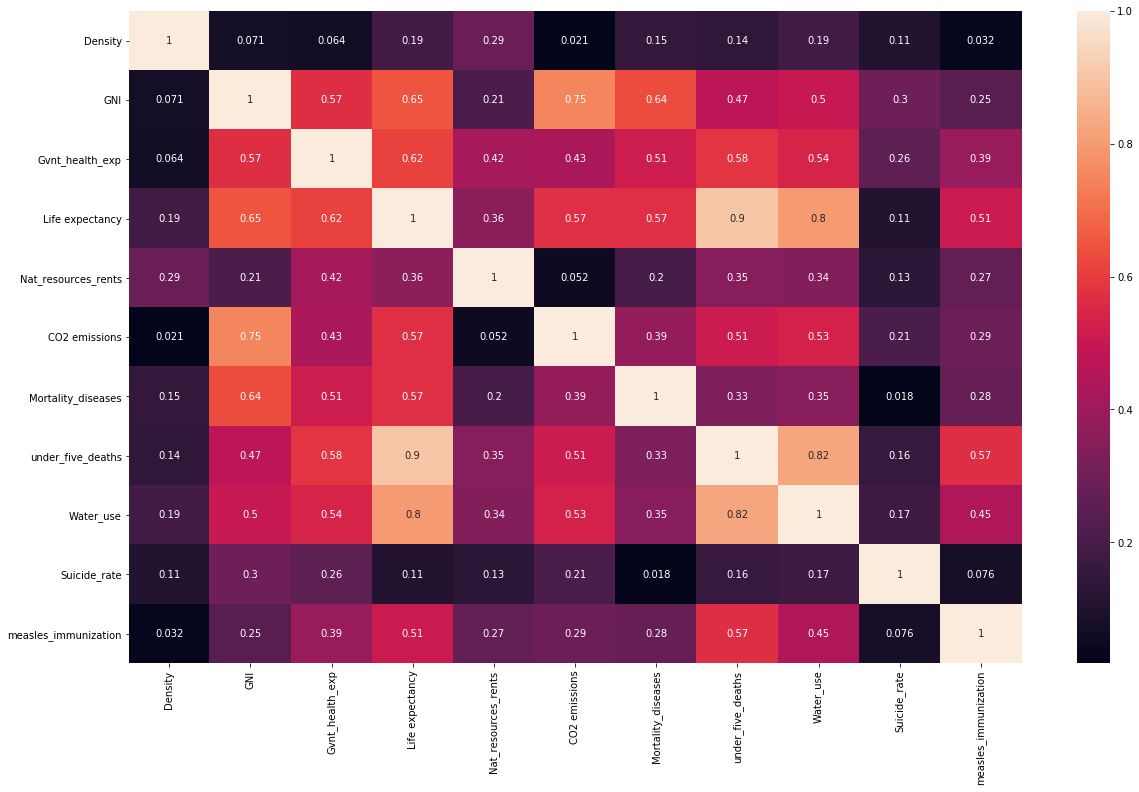

In [42]:
plt.figure(figsize=(20,12))
sns.heatmap(abs(datatri.corr()),annot=True)

Again, we can see that Life Expectancy is very correlated to different variables, which is normal as this point as we will create groups from their difference in Life expenctancy, and try to predict those groups thanks to the other variables. Other variables like GNI are also correlated to numerous variables. In the classification analysis, we will check that the correlations don't cause overfitting, and eventually remove correlated variables.

# Normalize data 

## clustering dataset

In [43]:
Z_dfautrestri = (dfautrestri - dfautrestri.mean())/dfautrestri.std()

## classification dataset

In [44]:
Z_datatri = (datatri - datatri.mean())/datatri.std()

# Clustering (dfautrestri)

## Hierarchical clustering

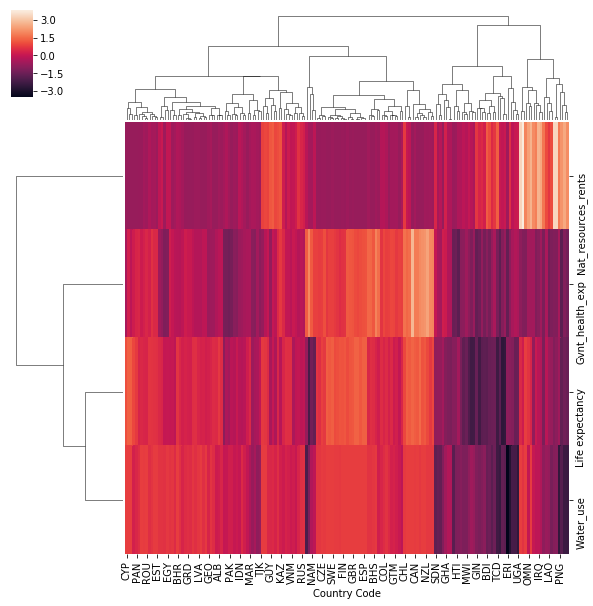

In [783]:
sns.clustermap(Z_dfautrestri.T,method='complete')

It seems that the clusters are characterized mostly by life expectancy and government health expenditure. However, we would like to have a more precise description.

### Agglomerative clustering

In order to do so, we decided to run an agglomerative clustering algorithm. We decided to generate 4 clusters as it seemed to be a reasonnable amount of clusters to describe our data, but we will later verify that this amount of clusters is coherent.

In [798]:
agc = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="average")
agc.fit(Z_dfautrestri)
        
dffdv = Z_dfautrestri.values # get the data matrix of values (dataframe feature data values)
clustersAgglo = (agc.labels_+1)*100 #cluster labels for each point
AggloLabels = map(str,sorted(set(clustersAgglo.tolist())))
AggloLabels

['100', '200', '300', '400']

In [799]:
Z_dfautrestri2=Z_dfautrestri.copy()

In [800]:
Z_dfautrestri2=Z_dfautrestri2.assign(cluster=clustersAgglo)

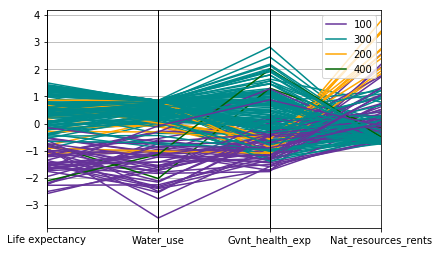

In [801]:
# Represent the clustered data using the parallel coordinates method
from pandas.plotting import parallel_coordinates
parallel_coordinates(Z_dfautrestri2,'cluster', color=('rebeccapurple', 'darkcyan', 'orange', 'darkgreen'))
plt.show()

Thanks to the parallel coordinate visualization, we can see how the variables discriminate the four clusters:
it seems that there is a first group of countries with low water use and low Life Expectancy values (purple). A second group of countries with high Government health expenditures, higher life expectancy and low ressources rents is represented in darkcyan. The two other groups are a bit confused, and don't seem to show a tendency. The yellow cluster seems to represent countries with highest natural ressources rents.

In [802]:
# to get feature importance
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(Z_dfautrestri, clustersAgglo)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [803]:
# feature importance
rf.feature_importances_

array([0.39175452, 0.30554649, 0.09853383, 0.20416516])

We can see that "Life expectancy" is the most important feature, used to discriminate the counttries into 4 groups. That information reinforce our choice of using this variable for classification. GNI is also an iportant feature, which is coherent knowing that we have both countries from third world and occidental countries.

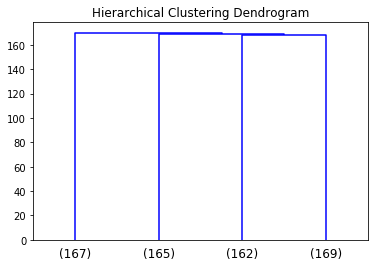

In [804]:
plt.title('Hierarchical Clustering Dendrogram')
plot_sklearn_dendrogram(agc, labels=agc.labels_, truncate_mode='lastp', p=4) #cf plot_sklearn_dendrogram.py
plt.show()

In [806]:
# silhouette score
metrics.silhouette_score(dffdv, clustersAgglo, metric='euclidean', sample_size=None) # sample_size=None for no sampling 

0.4281929037762835

Finally, the silhouette coeficient score calculated for this clustering is fair : it could be closer to 1 but it's stil acceptable. This means that the clusters given by the agglomerative method are not perfect, wich is probably because all the countries represented are not well discriminated : only two of the 4 clusters are really well established, and two others are really smaller.

## Kmeans

Before actually runing the Kmeans method on our data, we used the SSE and the silhouette coefficient in order to figure out the number of clusters we had generate. We also run a stability analysis to see if the algorithm is stable with the number of clusters we wanted.

In [810]:
## test du nombre de cluster:
SSE = [] #stockage des SSE pour chaque nombre de cluster
silh = [] #stockage des coeff silhouettes pour chaque nombre de cluster
for i in range(2,10):
    kmeans = KMeans(i)
    kmeans = kmeans.fit(Z_dfautrestri)
    Z_dfautrestri["cluster"] = kmeans.predict(Z_dfautrestri)
    SSE.append(kmeans.inertia_)
    silh.append(metrics.silhouette_score(Z_dfautrestri, Z_dfautrestri["cluster"], metric='euclidean', sample_size=None))

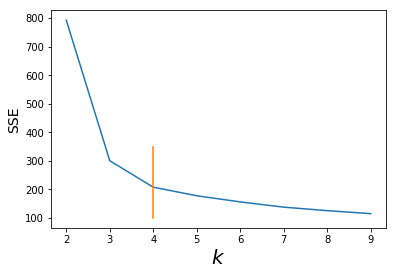

In [811]:
## graphe de la SSE:
plt.plot(range(2,10),SSE)
plt.plot([4,4],[100,350])
plt.xlabel("$k$",fontsize=20)
plt.ylabel("SSE",fontsize=14)

According to SSE, we can choose between 3 or 4 clusters.

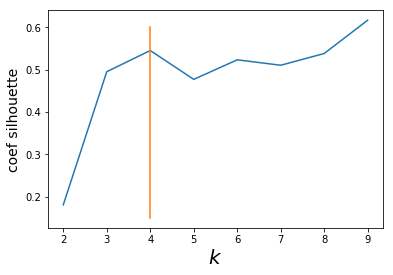

In [813]:
## coeff silhouette:
plt.plot(range(2,10),silh)
plt.plot([4,4],[0.15,0.6])
plt.xlabel("$k$",fontsize=20)
plt.ylabel("coef silhouette",fontsize=14)

The silhouette coeficient is slightly better with 4 clusters.

### Stability

In [814]:
silhouette_coef = []
sse = []
k = 4
n_init=1
for i in range(100):
    km = KMeans(n_clusters=k, n_init=n_init, random_state=i) # create a KMeans object
    km.fit(Z_dfautrestri)
    labels = km.predict(Z_dfautrestri)
    sse.append(km.inertia_)
    silhouette_coef.append(metrics.silhouette_score(Z_dfautrestri, labels, metric='euclidean', sample_size=None))

(array([62.,  0.,  2.,  0.,  0.,  8.,  7., 12.,  7.,  2.]),
 array([422.75380279, 435.10915518, 447.46450757, 459.81985996,
        472.17521235, 484.53056474, 496.88591713, 509.24126953,
        521.59662192, 533.95197431, 546.3073267 ]),
 <a list of 10 Patch objects>)

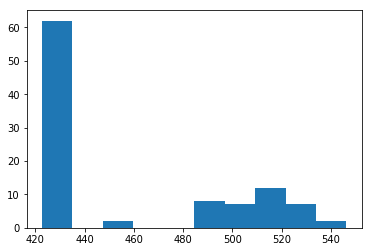

In [815]:
plt.hist(sse)

(array([ 1.,  0.,  2.,  8.,  8.,  1., 73.,  1.,  1.,  5.]),
 array([0.41008377, 0.42242402, 0.43476427, 0.44710452, 0.45944477,
        0.47178502, 0.48412527, 0.49646552, 0.50880577, 0.52114602,
        0.53348627]),
 <a list of 10 Patch objects>)

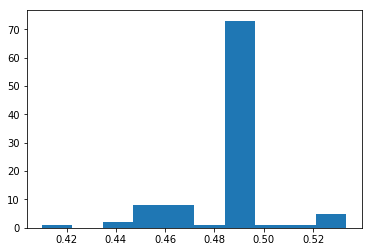

In [816]:
plt.hist(silhouette_coef)

According to the shape of the distributions above, we can say kmeans clustering is quite stable with 4 clusters, as we obtain the same values in the majority of the cases.

In [817]:
def compute_stability(k,df,iterations=100):
    silhouette_coef = []
    for i in range(iterations):
        km = KMeans(n_clusters=k, n_init=1, random_state=i) # create a KMeans object
        km.fit(df)
        labels = km.predict(df)
        silhouette_coef.append(metrics.silhouette_score(df, labels, metric='euclidean', sample_size=None))
    silhouette_coef = np.asarray(silhouette_coef)
    return(silhouette_coef.std())

In [818]:
stability = []
Ks = range(2,30)
for k in Ks:
    stability.append(compute_stability(k,Z_dfautrestri))

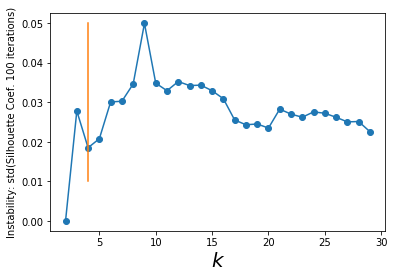

In [821]:
plt.plot(Ks,stability,"o-")
plt.plot([4,4],[0.01,0.050])
plt.xlabel("$k$",fontsize=20)
plt.ylabel("Instability: std(Silhouette Coef. 100 iterations)")

4 clusters seems like a good compromise between a low instability and a reasonable amount of clusters.

### KMeans clustering

In [825]:
# final clustering
from sklearn.cluster import KMeans
kmeans = KMeans(4)
kmeans = kmeans.fit(Z_dfautrestri)
Z_dfautrestri["cluster"] = kmeans.predict(Z_dfautrestri)

In [826]:
metrics.silhouette_score(Z_dfautrestri, Z_dfautrestri["cluster"], metric='euclidean', sample_size=None)

0.5220019941090359

As expected, the silhouette score is better than the one we obtained with the previous clustering method

In [827]:
sse = kmeans.inertia_
print("sse =", sse)

('sse =', 203.9488144840027)


In [828]:
KLabels = map(str,sorted(set(kmeans.predict(Z_dfautrestri).tolist())))
KLabels

['0', '1', '2', '3']

### Parallel coordinates method to represent the clustered data

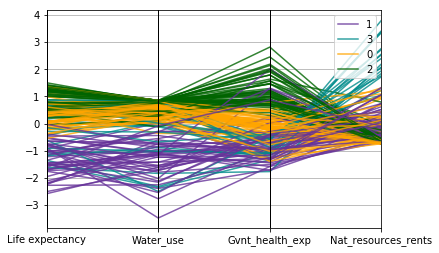

In [831]:
# Represent the clustered data using the parallel coordinates method
from pandas.plotting import parallel_coordinates
parallel_coordinates(Z_dfautrestri,'cluster', color=('rebeccapurple', 'darkcyan', 'orange', 'darkgreen'),alpha=0.8)
plt.show()

As we can see on this representation, the clusters are well discriminated, and we can easily identify 4 groups, unlike the clusters given by the agglomerative method previously used.

### Use a decision Tree to Describe the Clusters

In order to get a complementary characterization, we used a Decision Tree to describe the clusters. A max_depth of 3 seemed like a good compromise between a low entropy and the number of sample per leaves

In [832]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix

In [833]:
dt = DecisionTreeClassifier(max_depth=3,criterion="entropy")
prediction_features = [c for c in Z_dfautrestri.columns if c != "cluster"]
dt = dt.fit(Z_dfautrestri[prediction_features],Z_dfautrestri["cluster"])

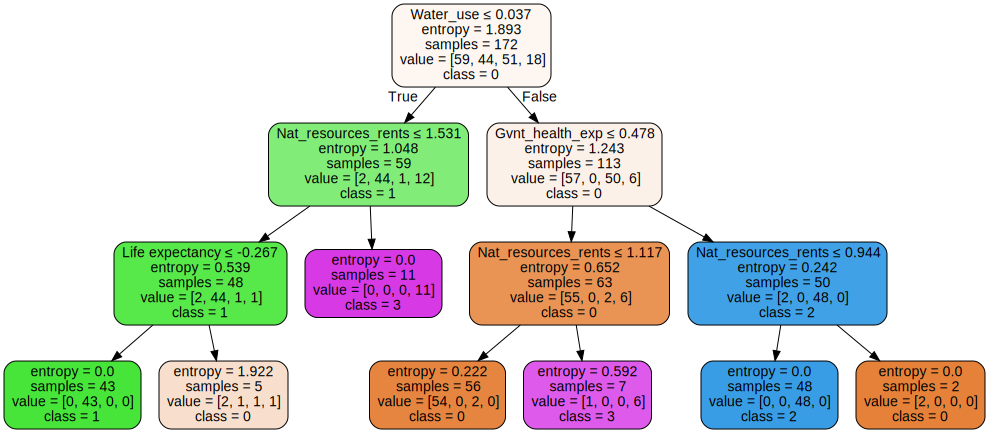

In [834]:
dot_data = export_graphviz(dt, out_file=None, 
                         feature_names=prediction_features,  
                         class_names=["0","1","2","3"], # needs to be lexicographically sorted
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(dot_data)
graph

In this instance, we can see how the different classes are characterized: 
- class 0 : high water use with low government health expenditures and somewhat low natural resources rents (eg : Brazil, Bolivia, Ukrania)
- class 1 : low government health expenditure, water use and natural resources rents (eg : Yemen, Benin, Afghanistan)
- class 2 : high government health expenditure, water use and low natural resources rents (eg : Australia, Canada, Sweden)
- class 3 : higest natural resources rents(eg : Angola, Koweit, Libya)

We can also visualize the clusters described above with the pairplots below:

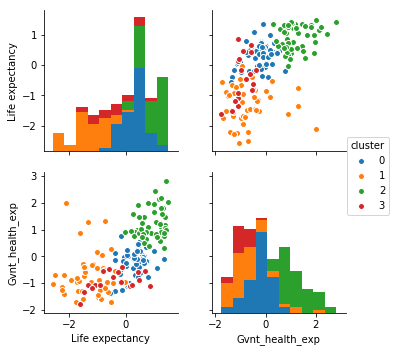

In [841]:
sns.pairplot(Z_dfautrestri,vars=["Life expectancy","Gvnt_health_exp"],hue="cluster")

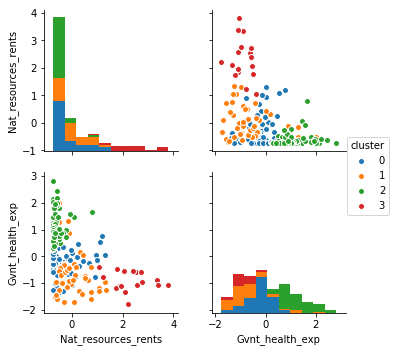

In [842]:
sns.pairplot(Z_dfautrestri,vars=["Nat_resources_rents","Gvnt_health_exp"],hue="cluster")

## DBSCAN

We then decided to try a second clustering method, that we could compare to Kmeans afterwards.

In [845]:
dbscan = DBSCAN(eps=0.9, min_samples=10)
dbscan.fit(Z_dfautrestri)

DBSCAN(algorithm='auto', eps=0.9, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=10, n_jobs=1, p=None)

In [846]:
values = Z_dfautrestri.values 
clustersDBS = dbscan.labels_
clustersDBS=(clustersDBS+2)*10
Z_dfautrestri3=Z_dfautrestri.copy()
Z_dfautrestri3=Z_dfautrestri3.assign(cluster=clustersDBS)

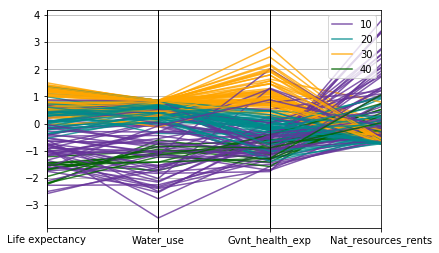

In [847]:
# Represent the clustered data using the parallel coordinates method
from pandas.plotting import parallel_coordinates
parallel_coordinates(Z_dfautrestri3,'cluster', color=('rebeccapurple', 'darkcyan', 'orange', 'darkgreen','black'),alpha=0.8)
plt.show()

In [848]:
metrics.silhouette_score(values, clustersDBS, metric='euclidean', sample_size=None) # sample_size=None for no sampling 

0.3520004816489918

With DBSCAN, the silhouette coeficient is the lowest, but the clusters still seems more defined than the ones we had with the agglomerative method, according to the representation above.

In [850]:
DBSCANLabels = map(str,sorted(set(clustersDBS.tolist())))
DBSCANLabels

['10', '20', '30', '40']

## Comparing the different clustering methods

### Confusion matrix

#### Kmeans vs DBscan

In [851]:
allLabels = KLabels + DBSCANLabels
allLabels

['0', '1', '2', '3', '10', '20', '30', '40']

In [852]:
cm1 = metrics.confusion_matrix(Z_dfautrestri["cluster"].astype(str), clustersDBS.astype(str),labels=allLabels)
cm1.shape

(8, 8)

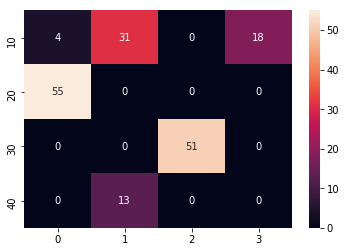

In [853]:
cmdf1 = pd.DataFrame(data=cm1, copy=True, index=allLabels, columns=allLabels).loc[KLabels, DBSCANLabels]
cmdf1 = cmdf1.transpose()
sns.heatmap(cmdf1, annot=True)

The confusion matrix shows us that clusters 2 and 30 (resp. from Kmeans and DBSCAN) are alike, whereas cluster 10 is mostly a combination of clusters 1 and 3. The repartition of the countries according to the 2 algorithms isn't completely the same  even though they are somewhat close.

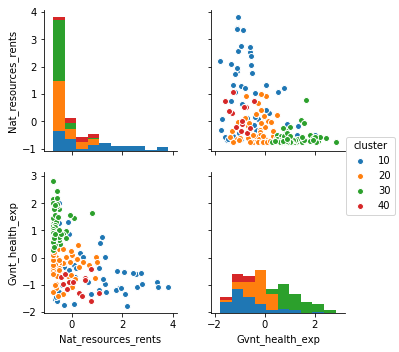

In [854]:
# DBSCAN clusters representation
sns.pairplot(Z_dfautrestri3,vars=["Nat_resources_rents","Gvnt_health_exp"],hue="cluster")

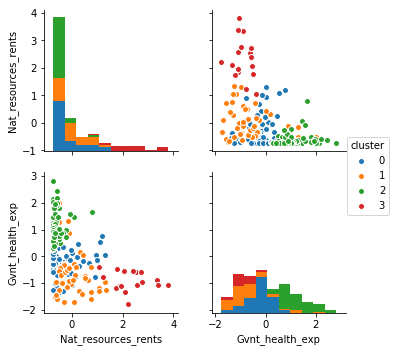

In [855]:
# Kmeans clusters representation
sns.pairplot(Z_dfautrestri,vars=["Nat_resources_rents","Gvnt_health_exp"],hue="cluster")

The DBSCAN clusters seem to be a bit more "confused" than the Kmeans clusters, but we can still identify 4 groups.

#### Kmeans vs Agglomerative clusterring

We repeated the same procedure to compare Kmeans and Agglomerative clusters.

In [856]:
allLabels2 = KLabels + AggloLabels
allLabels2

['0', '1', '2', '3', '100', '200', '300', '400']

In [857]:
cm2 = metrics.confusion_matrix(Z_dfautrestri["cluster"].astype(str), clustersAgglo.astype(str),labels=allLabels2)
cm2.shape

(8, 8)

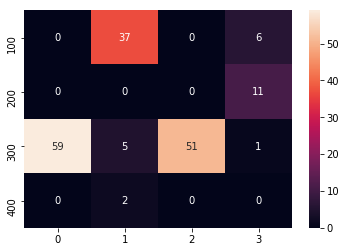

In [858]:
cmdf2 = pd.DataFrame(data=cm2, copy=True, index=allLabels2, columns=allLabels2).loc[KLabels, AggloLabels]
cmdf2 = cmdf2.transpose()
sns.heatmap(cmdf2, annot=True)

The difference between the two methods is bigger than the previous comparison. Agglomerative clustering gave one big cluster and 2 very small groups with extreme values, which is coherent with an agglomarative representation of the data, and well illustrated by the representation below :

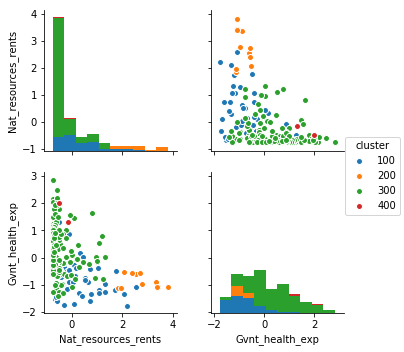

In [861]:
# Agglomerative clusters representation
sns.pairplot(Z_dfautrestri2,vars=["Nat_resources_rents","Gvnt_health_exp"],hue="cluster")

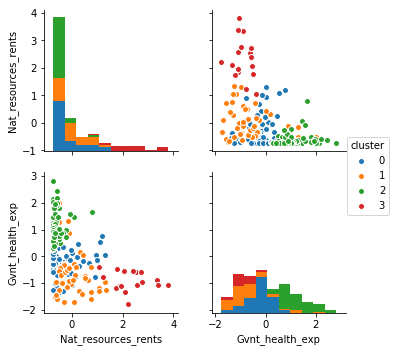

In [862]:
# Kmeans clusters representation
sns.pairplot(Z_dfautrestri,vars=["Nat_resources_rents","Gvnt_health_exp"],hue="cluster")

### Entropy

#### Kmeans vs DBscan

In [863]:
proba = 0.1*cmdf1.values/cmdf1.values.sum(axis=1, keepdims=True) # divide each element of a row by the sum of the row
print(proba)
entropy = [stats.entropy(row, base=2) for row in proba]
print "entropy of each cluster:", entropy

[[0.00754717 0.05849057 0.         0.03396226]
 [0.1        0.         0.         0.        ]
 [0.         0.         0.1        0.        ]
 [0.         0.1        0.         0.        ]]
entropy of each cluster: [1.2630386498848076, 0.0, 0.0, 0.0]


The last 3 clusters are globally the same with the two methods, as we've seen in the confusion matrix. Only the fisrt one differs with an entropy >0.

#### Kmeans vs Agglomerative clusterring

In [864]:
proba = 0.1*cmdf2.values/cmdf2.values.sum(axis=1, keepdims=True) # divide each element of a row by the sum of the row
print(proba)
entropy = [stats.entropy(row, base=2) for row in proba]
print "entropy of each cluster:", entropy

[[0.         0.08604651 0.         0.01395349]
 [0.         0.         0.         0.1       ]
 [0.05086207 0.00431034 0.04396552 0.00086207]
 [0.         0.1        0.         0.        ]]
entropy of each cluster: [0.5830194167347008, 0.0, 1.2719527810988505, 0.0]


Here we can see that only 2 clusters are alike, and the two others remain quite differents.

# Clustering - Conclusion

As we saw with this first part of our analysis, it seems that the countries can be divided into 4 clusters. Thanks to the Kmeans clustering and a decision tree algorithm we were able to identify those four groups :
 - Western countries (class 2 with Kmeans)
 - Third world countries (class 1)
 - Developing countries (class 0)
 - Countries with high ressources such as oil producing countries (class 3)
 
The Kmeans algorithm was run multiple times and rather stable with our data. The 4 clusters were clearly defined. DBSCAN still managed to identify those 4 clusters but with some differences. The agglomerative method couldn't separate well our countries based on the variables we provided : only one big cluster was created and the other clusters were made out of the extreme values, because our data were too agglomerated for the algorithm to really discriminate 4 groups.


# Classification

As we briefly explained before, we decided to create classes amoung the countries, according to their Life expectancy values, and we will try to predict them thanks to the remaining variables, all more or less connected or having an effect on the Life expectancy value of a country.

## Construct the labels

#### Manually defined labels

In [200]:
sort_datatri=Z_datatri.sort_values('Life expectancy') # sort the normalized data
n=len(sort_datatri)

At first, we decided to manually construct three classes by dividing the countries into 3 even groups :
    - class 1 : low life expectancy
    - class 2 : medium life expectancy
    - class 3 : high life expectancy

In [201]:
x=np.array(['1','2','3']) # array needed to create the classes array
classes=np.repeat(x, floor(n/3))

In [202]:
sort_datatri=sort_datatri.assign(classe=classes) # assign each country to a class
sort_datatri=sort_datatri.drop(labels='Life expectancy', axis=1)
sort_datatri.head()

,Density,GNI,Gvnt_health_exp,Nat_resources_rents,CO2 emissions,Mortality_diseases,under_five_deaths,Water_use,Suicide_rate,measles_immunization,classe
Country Code,,,,,,,,,,,
CIV,-0.345480,-0.643145,-1.165594,-0.158873,-0.804511,1.505957,2.207067,-0.626843,0.597527,-1.501443,1
LSO,-0.324799,-0.620184,-0.736341,-0.399207,-0.618693,1.220220,1.231279,-0.775822,1.859909,0.008388,1
NGA,0.222929,-0.566042,-1.445910,0.456767,-0.747984,0.488016,3.005836,-1.278786,0.136929,-2.675756,1
SWZ,-0.313911,-0.468809,2.012711,-0.472230,-0.679449,1.148785,1.288937,-1.188873,0.461054,0.511665,1
ZWE,-0.488213,-0.684824,-0.919679,0.080113,-0.753973,0.166561,1.432004,-0.874396,0.461054,0.176147,1


#### Labels defined by a KMeans clustering

Then we also tried to create more accurate classes : each country will be distributed into a class by a Kmeans algorithm.

In [203]:
kmeans = KMeans(3)
kmeans = kmeans.fit(Z_datatri.loc[:,"Life expectancy"].values.reshape(-1, 1))
classes2= kmeans.predict(Z_datatri.loc[:,"Life expectancy"].values.reshape(-1, 1)).astype(str) 
sort_datatri2=sort_datatri.copy()
sort_datatri2=sort_datatri.assign(classe=classes2) # assign each country to a class
sort_datatri2.head()

,Density,GNI,Gvnt_health_exp,Nat_resources_rents,CO2 emissions,Mortality_diseases,under_five_deaths,Water_use,Suicide_rate,measles_immunization,classe
Country Code,,,,,,,,,,,
CIV,-0.345480,-0.643145,-1.165594,-0.158873,-0.804511,1.505957,2.207067,-0.626843,0.597527,-1.501443,2
LSO,-0.324799,-0.620184,-0.736341,-0.399207,-0.618693,1.220220,1.231279,-0.775822,1.859909,0.008388,1
NGA,0.222929,-0.566042,-1.445910,0.456767,-0.747984,0.488016,3.005836,-1.278786,0.136929,-2.675756,1
SWZ,-0.313911,-0.468809,2.012711,-0.472230,-0.679449,1.148785,1.288937,-1.188873,0.461054,0.511665,1
ZWE,-0.488213,-0.684824,-0.919679,0.080113,-0.753973,0.166561,1.432004,-0.874396,0.461054,0.176147,1


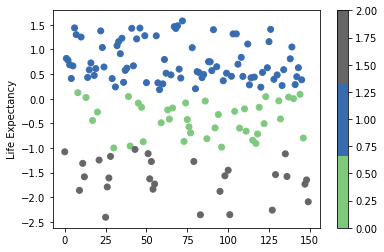

In [204]:
# Visualization of the three clusters in term of Life expectancy
Z_datatri_copy=Z_datatri.copy() 
Z_datatri_copy=Z_datatri_copy.assign(classe=classes2) # assigned each coutry to a class
plt.scatter(range(len(Z_datatri_copy.loc[:,"Life expectancy"].values)),Z_datatri_copy.loc[:,"Life expectancy"].values,c=classes2,cmap=plt.cm.get_cmap("Accent", 3))
plt.ylabel("Life Expectancy")
plt.colorbar()
plt.show()

We can see that we have three classe defined by:
    - class 0 : medium life expectancy
    - class 2 : high life expectancy
    - class 1 : low life expectancy

All the country are evenly distributed into 3 classes of similar size.

## KNN Classification

###  KNN Classification with the manually defined labels

In [205]:
from sklearn.model_selection import train_test_split
from sklearn import neighbors
data_train, data_test, label_train, label_test = train_test_split(sort_datatri, classes, test_size=0.33, random_state=10)
sortedLabelList = sorted(list(set(classes)))

In [206]:
# knn model
model = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', p=2)

In [207]:
# Training
model.fit(data_train, label_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [208]:
# Testing
label_predict = model.predict(data_test)
print('accuracy = ', metrics.accuracy_score(label_test, label_predict))
print(metrics.classification_report(label_test, label_predict))

('accuracy = ', 0.9)
             precision    recall  f1-score   support

          1       0.94      1.00      0.97        15
          2       0.85      0.89      0.87        19
          3       0.93      0.81      0.87        16

avg / total       0.90      0.90      0.90        50



In [209]:
# Confusion matrix
import pandas as pds
pds.DataFrame(
    metrics.confusion_matrix(y_true=label_test, y_pred=label_predict, labels=sortedLabelList),
    columns=['Predicted ' + str(className) for className in sortedLabelList],
    index=['True ' + str(className) for className in sortedLabelList]
)

,Predicted 1,Predicted 2,Predicted 3
True 1,15,0,0
True 2,1,17,1
True 3,0,3,13


Both accuracy and precision are about 0.90, which is high : all the classes are almost perfectly predictedwith only few misclassifications.

#### Cross-validation

In [210]:
from sklearn.model_selection import StratifiedKFold,cross_validate
scoring = ['accuracy', 'precision_weighted',  'recall_weighted',  'f1_weighted']
cv = StratifiedKFold(n_splits=8, random_state=10, shuffle=True) 
scores = cross_validate(model, sort_datatri, classes, scoring=scoring, cv=cv, return_train_score=False) 
scores

{'fit_time': array([0.00097203, 0.00083208, 0.00081706, 0.00088596, 0.00093699,
        0.00069594, 0.00069404, 0.00069213]),
 'score_time': array([0.00298786, 0.00283694, 0.00294089, 0.00285196, 0.00258398,
        0.00254703, 0.00254798, 0.00328088]),
 'test_accuracy': array([0.80952381, 0.95238095, 0.88888889, 0.88888889, 0.83333333,
        1.        , 0.88888889, 0.83333333]),
 'test_f1_weighted': array([0.80753968, 0.95213675, 0.88205128, 0.88850039, 0.83216783,
        1.        , 0.88571429, 0.83636364]),
 'test_precision_weighted': array([0.83068783, 0.95833333, 0.9047619 , 0.8968254 , 0.83809524,
        1.        , 0.91666667, 0.88888889]),
 'test_recall_weighted': array([0.80952381, 0.95238095, 0.88888889, 0.88888889, 0.83333333,
        1.        , 0.88888889, 0.83333333])}

Through the cross-validation process, we can see that the scoring metrics remain quite high. 

#### Testing overfitting

We want now to see whether there is any overfitting.

In [211]:
# variation of the number of neighbours
train_accuracy = []
test_accuracy = []
for i in range(1,30):
    model_i = neighbors.KNeighborsClassifier(n_neighbors=i, weights='uniform', p=2)
    # Training
    model_i.fit(data_train, label_train)
    train_predict = model_i.predict(data_train)
    # Testing
    test_predict = model_i.predict(data_test)
    train_accuracy.append(metrics.accuracy_score(label_train, train_predict))
    test_accuracy.append(metrics.accuracy_score(label_test, test_predict))

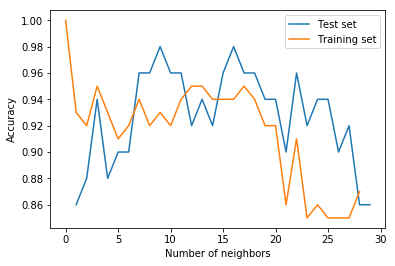

In [212]:
# plot of the training and testing accuracy vs the number of neighbors
plt.plot(range(1,30), test_accuracy, label="Test set")
plt.plot(train_accuracy, label="Training set")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Number of neighbors")

We can see that, as the number of neighbors increases, the test accuracy and training accuracies remain close. Thus, there does not seem to be any overfitting. Furthermore, the accuracy remains very high.

## KNN Classification with the kmeans labels

In [213]:
data_train, data_test, label_train, label_test = train_test_split(sort_datatri2, classes2, test_size=0.33, random_state=10)
sortedLabelList = sorted(list(set(classes2)))

In [214]:
# knn model
model_knn_2 = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', p=2)

In [215]:
# Training
model_knn_2.fit(data_train, label_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [216]:
# Testing
label_predict = model_knn_2.predict(data_test)
print('accuracy = ', metrics.accuracy_score(label_test, label_predict))
print(metrics.classification_report(label_test, label_predict))

('accuracy = ', 0.64)
             precision    recall  f1-score   support

          0       0.50      0.42      0.45        12
          1       0.66      0.83      0.74        30
          2       1.00      0.25      0.40         8

avg / total       0.67      0.64      0.61        50



In [217]:
# Confusion matrix
import pandas as pds
pds.DataFrame(
    metrics.confusion_matrix(y_true=label_test, y_pred=label_predict, labels=sortedLabelList),
    columns=['Predicted ' + str(className) for className in sortedLabelList],
    index=['True ' + str(className) for className in sortedLabelList]
)

,Predicted 0,Predicted 1,Predicted 2
True 0,5,7,0
True 1,5,25,0
True 2,0,6,2


Both accuracy and precision are lower, with values around 0.8, but it is still high. In addition, we can see in the confusion matrix that there were a bit more misclassifications.

#### Cross-validation

In [218]:
from sklearn.model_selection import StratifiedKFold,cross_validate
scoring = ['accuracy', 'precision_weighted','recall_weighted', 'f1_weighted']
cv = StratifiedKFold(n_splits=8, random_state=10, shuffle=True) 
scores = cross_validate(model_knn_2, sort_datatri2, classes2, scoring=scoring, cv=cv, return_train_score=False) 
scores

{'fit_time': array([0.00097108, 0.00095987, 0.00080895, 0.00097203, 0.00085187,
        0.00081778, 0.00120783, 0.00078297]),
 'score_time': array([0.00314593, 0.00277615, 0.00271606, 0.00301194, 0.00277114,
        0.00263023, 0.00280595, 0.00252485]),
 'test_accuracy': array([0.65      , 0.8       , 0.52631579, 0.63157895, 0.72222222,
        0.77777778, 0.77777778, 0.66666667]),
 'test_f1_weighted': array([0.56009852, 0.79166667, 0.42606516, 0.62155388, 0.72248804,
        0.77306397, 0.70707071, 0.60327635]),
 'test_precision_weighted': array([0.58611111, 0.82307692, 0.41021672, 0.61562998, 0.72839506,
        0.79166667, 0.64814815, 0.79166667]),
 'test_recall_weighted': array([0.65      , 0.8       , 0.52631579, 0.63157895, 0.72222222,
        0.77777778, 0.77777778, 0.66666667])}

We can see that the different metrics vary a little from one kind of partition to another and are a bit lower than with the previous classification. However, they remain quite high (>0.6)

#### Testing overfitting

In [219]:
# variation of the number of neighbours
train_accuracy = []
test_accuracy = []
for i in range(1,30):
    model_i = neighbors.KNeighborsClassifier(n_neighbors=i, weights='uniform', p=2)
    # Training
    model_i.fit(data_train, label_train)
    train_predict = model_i.predict(data_train)
    # Testing
    test_predict = model_i.predict(data_test)
    train_accuracy.append(metrics.accuracy_score(label_train, train_predict))
    test_accuracy.append(metrics.accuracy_score(label_test, test_predict))

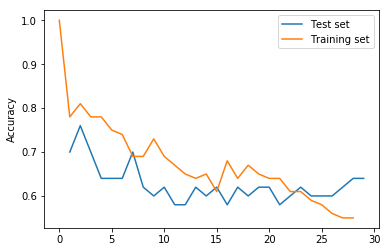

In [220]:
plt.plot(range(1,30),test_accuracy, label="Test set")
plt.plot(train_accuracy, label="Training set")
plt.legend()
plt.ylabel("Accuracy")

We can see that, as the number of neighbors increases, the test accuracy and training accuracy remain close. Thus, there does not seem to be any overfitting. Furthermore, the accuracy remains quite high even though it's lower than with the previous classification.

## Decision Tree with manual labels

In [221]:
data=sort_datatri.drop(labels='classe', axis=1)
data_train, data_test, label_train, label_test = train_test_split(data, classes, test_size=0.33, random_state=10)
sortedLabelList = sorted(list(set(classes)))
dt = DecisionTreeClassifier(max_depth=3,criterion="entropy")
dt = dt.fit(data_train,label_train)
tree_predict=dt.predict(data_test)

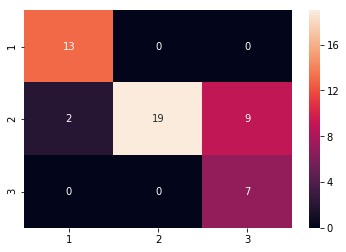

In [222]:
cm3 = metrics.confusion_matrix(label_test, tree_predict)
cm3.shape
cmdf3 = pd.DataFrame(data=cm3, copy=True,index=sortedLabelList,columns=sortedLabelList).loc[sortedLabelList,sortedLabelList]
cmdf3 = cmdf3.transpose()
sns.heatmap(cmdf3, annot=True)

In [223]:
metrics.accuracy_score(label_test,tree_predict)

0.78

As the confusion matrix and accuracy score show, the decision tree algorithm succeeded to classify our data into 2 of the 3 groups with the manually-made labels. The third group however has some misclassifications. The accuracy is lower than the one obtained with KNN method.

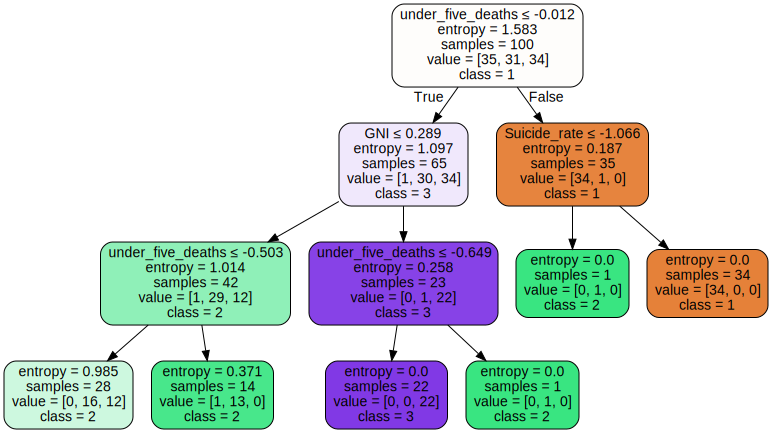

In [224]:
dot_data = export_graphviz(dt, out_file=None, 
                         feature_names=data.columns,  
                         class_names=sortedLabelList, # needs to be lexicographically sorted
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(dot_data)
graph

Here we can see how the countries were distributed into the 3 classes. under five deaths values, GNI and Suicide rate were used.

#### Cross-validation

In [225]:
scoring = ['accuracy', 'precision_weighted',  'recall_weighted',  'f1_weighted']
cv = StratifiedKFold(n_splits=8, random_state=10, shuffle=True) 
scores = cross_validate(dt, data, classes, scoring=scoring, cv=cv, return_train_score=False) 
scores

{'fit_time': array([0.00174117, 0.00139594, 0.00120091, 0.00160408, 0.00134206,
        0.00127602, 0.00120711, 0.00107408]),
 'score_time': array([0.00165892, 0.00125718, 0.00133014, 0.00133991, 0.00128984,
        0.00161886, 0.00124097, 0.00116086]),
 'test_accuracy': array([0.85714286, 0.76190476, 0.77777778, 0.83333333, 0.72222222,
        0.83333333, 0.66666667, 0.83333333]),
 'test_f1_weighted': array([0.86007326, 0.75433455, 0.76800977, 0.83076923, 0.66386555,
        0.83216783, 0.65555556, 0.83216783]),
 'test_precision_weighted': array([0.86904762, 0.75198413, 0.82738095, 0.85714286, 0.84848485,
        0.83809524, 0.72222222, 0.83809524]),
 'test_recall_weighted': array([0.85714286, 0.76190476, 0.77777778, 0.83333333, 0.72222222,
        0.83333333, 0.66666667, 0.83333333])}

All the metrics are high (>0.7) for the different partitions.

#### Testing overfitting

In [226]:
accuracy_train = []
accuracy_test = []
for i in range(2,20):
    dt = DecisionTreeClassifier(max_depth=i,criterion="entropy")
    dt = dt.fit(data_train,label_train)
    
    tree_predict_train=dt.predict(data_train)
    tree_predict_test=dt.predict(data_test)

    accuracy_train.append(metrics.accuracy_score(label_train,tree_predict_train))
    accuracy_test.append(metrics.accuracy_score(label_test,tree_predict_test))

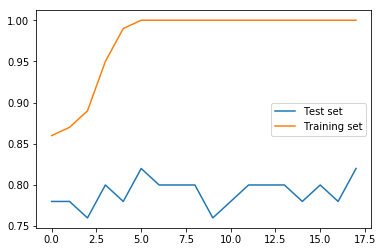

In [227]:
plt.plot(accuracy_test,label="Test set")
plt.plot(accuracy_train,label="Training set")
plt.legend()

As we can see on the representation above, when the number of neighbors increases the train accuracy and test accuracy don't grow together but stay identical. Therefore, there is some overfitting.

## Decision Tree with Kmeans labels

In [228]:
data=sort_datatri2.drop(labels='classe', axis=1)
data_train, data_test, label_train, label_test = train_test_split(data, classes2, test_size=0.33, random_state=10)
sortedLabelList = sorted(list(set(classes2)))
dt = DecisionTreeClassifier(max_depth=3,criterion="entropy")
dt = dt.fit(data_train,label_train)
tree_predict=dt.predict(data_test)

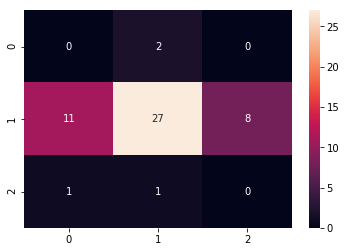

In [229]:
cm3 = metrics.confusion_matrix(label_test, tree_predict)
cm3.shape
cmdf3 = pd.DataFrame(data=cm3, copy=True,index=sortedLabelList,columns=sortedLabelList).loc[sortedLabelList,sortedLabelList]
cmdf3 = cmdf3.transpose()
sns.heatmap(cmdf3, annot=True)

In [230]:
metrics.accuracy_score(label_test,tree_predict)

0.54

The accuracy score is low (<0.6) which means our algorithm couldn't really classify properly our data. As the confusion matric shows almost all the countries were put in one single class.

#### Cross-validation

In [231]:
scoring = ['accuracy', 'precision_weighted',  'recall_weighted',  'f1_weighted']
cv = StratifiedKFold(n_splits=8, random_state=10, shuffle=True) 
scores = cross_validate(dt, data, classes2, scoring=scoring, cv=cv, return_train_score=False) 
scores

{'fit_time': array([0.00157785, 0.00132585, 0.00156808, 0.00186205, 0.00144911,
        0.00136995, 0.00128317, 0.00134802]),
 'score_time': array([0.001297  , 0.00131917, 0.00156903, 0.00144911, 0.0012989 ,
        0.00118899, 0.0014379 , 0.00115585]),
 'test_accuracy': array([0.45      , 0.4       , 0.42105263, 0.31578947, 0.38888889,
        0.5       , 0.55555556, 0.5       ]),
 'test_f1_weighted': array([0.34137931, 0.39390097, 0.31189084, 0.26315789, 0.32407407,
        0.49242424, 0.47839506, 0.48611111]),
 'test_precision_weighted': array([0.275     , 0.39833333, 0.24767802, 0.22556391, 0.27777778,
        0.5462963 , 0.4265873 , 0.49259259]),
 'test_recall_weighted': array([0.45      , 0.4       , 0.42105263, 0.31578947, 0.38888889,
        0.5       , 0.55555556, 0.5       ])}

As expected, the different values for each metrics are sgnificatively lower.

#### Testing overfitting

In [232]:
accuracy_train = []
accuracy_test = []
for i in range(2,20):
    dt = DecisionTreeClassifier(max_depth=i,criterion="entropy")
    dt = dt.fit(data_train,label_train)
    
    tree_predict_train=dt.predict(data_train)
    tree_predict_test=dt.predict(data_test)

    accuracy_train.append(metrics.accuracy_score(label_train,tree_predict_train))
    accuracy_test.append(metrics.accuracy_score(label_test,tree_predict_test))

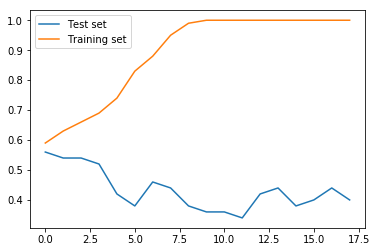

In [233]:
plt.plot(accuracy_test,label="Test set")
plt.plot(accuracy_train,label="Training set")
plt.legend()

Again, it seems that there is an overfitting effect, probably affecting the efficiency of the decision tree algorithm.

### Removing correlated variables 

As we previously saw, a few variables are very correlated to some others. To see if maybe this was the cause for our overfitting effetc in Decision tree classification, we decided to remove GNI, as it was correlated to 

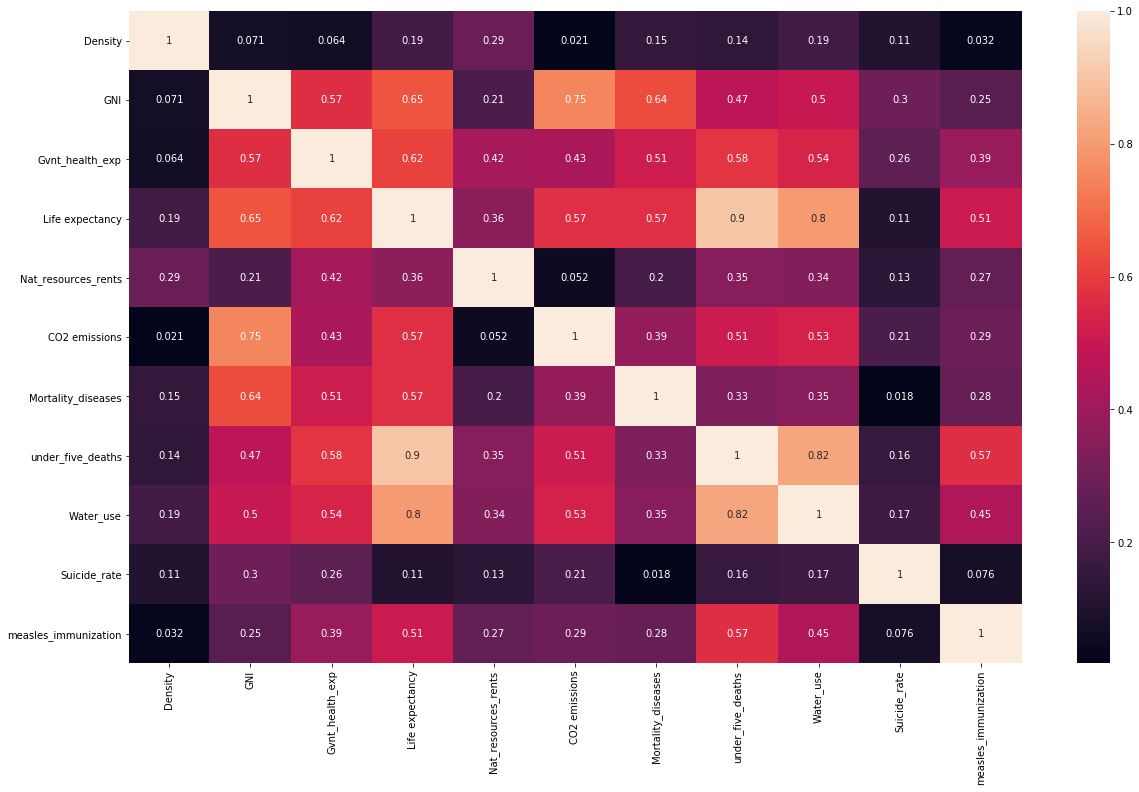

In [234]:
plt.figure(figsize=(20,12))
sns.heatmap(abs(datatri.corr()),annot=True)

In [235]:
Z_datatri_copy=Z_datatri.copy()
Z_datatri_copy=Z_datatri_copy.drop(columns=["GNI"])

In [236]:
kmeans = KMeans(3)
kmeans = kmeans.fit(Z_datatri_copy.loc[:,"Life expectancy"].values.reshape(-1, 1))
classes3 = kmeans.predict(Z_datatri_copy.loc[:,"Life expectancy"].values.reshape(-1, 1)).astype(str) 
Z_datatri_copy=Z_datatri_copy.drop(columns=['Life expectancy'])

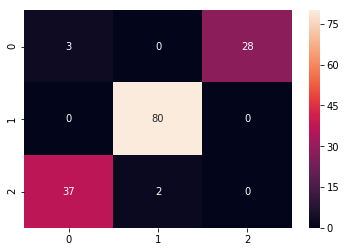

In [237]:
cm5 = metrics.confusion_matrix(classes2, classes3)
sortedLabelList=sorted(list(set(classes3)))
cmdf5 = pd.DataFrame(data=cm5, copy=True,index=sortedLabelList,columns=sortedLabelList).loc[sortedLabelList,sortedLabelList]
cmdf5 = cmdf5.transpose()
sns.heatmap(cmdf5, annot=True)

The classes found with and without GNI variable are almost the same.

## Decision Tree with Kmeans labels

In [255]:
data_train, data_test, label_train, label_test = train_test_split(Z_datatri_copy, classes3, test_size=0.33, random_state=10)
sortedLabelList = sorted(list(set(classes3)))
dt = DecisionTreeClassifier(max_depth=2,criterion="entropy")
dt = dt.fit(data_train,label_train)
tree_predict=dt.predict(data_test)

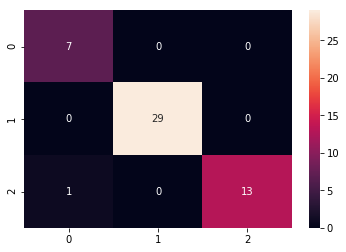

In [256]:
cm4 = metrics.confusion_matrix(label_test, tree_predict)
cm4.shape
cmdf4 = pd.DataFrame(data=cm4, copy=True,index=sortedLabelList,columns=sortedLabelList).loc[sortedLabelList,sortedLabelList]
cmdf4 = cmdf4.transpose()
sns.heatmap(cmdf4, annot=True)

In [257]:
metrics.accuracy_score(label_test,tree_predict)

0.98

With the removal of the GNI variable, the algorithm can discriminate 3 different groups, as we can see on the confusion matrix. The accuracy score is much higher than before.

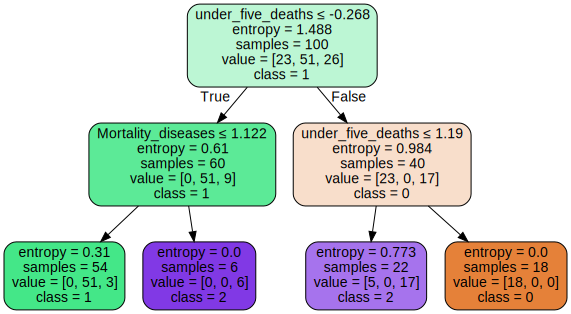

In [258]:
dot_data = export_graphviz(dt, out_file=None, 
                         feature_names=Z_datatri_copy.columns,  
                         class_names=sortedLabelList, # needs to be lexicographically sorted
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(dot_data)
graph

As we can see on the tree, the variables used were under five death and mortality diseases, which explains why the algorithm is more accurate this time : those variables are more correlated than GNI, which was previously used.

#### Cross-validation

In [259]:
scoring = ['accuracy', 'precision_weighted',  'recall_weighted',  'f1_weighted']
cv = StratifiedKFold(n_splits=8, random_state=10, shuffle=True) 
scores = cross_validate(dt, Z_datatri_copy, classes3, scoring=scoring, cv=cv, return_train_score=False) 
scores

{'fit_time': array([0.00146413, 0.00113893, 0.00102592, 0.00097704, 0.00116897,
        0.00107503, 0.00102186, 0.00111389]),
 'score_time': array([0.00141907, 0.00128388, 0.001333  , 0.00127506, 0.00129604,
        0.001266  , 0.00141406, 0.00124812]),
 'test_accuracy': array([1.        , 0.94736842, 0.94736842, 1.        , 0.84210526,
        0.84210526, 0.94736842, 0.88235294]),
 'test_f1_weighted': array([1.        , 0.94569758, 0.94600137, 1.        , 0.81295547,
        0.8455229 , 0.94569758, 0.87787115]),
 'test_precision_weighted': array([1.        , 0.95215311, 0.95614035, 1.        , 0.90131579,
        0.85964912, 0.95215311, 0.88770053]),
 'test_recall_weighted': array([1.        , 0.94736842, 0.94736842, 1.        , 0.84210526,
        0.84210526, 0.94736842, 0.88235294])}

All the metrics are high, but the values may vary a little from one partition to another.

#### Testing overfitting

In [260]:
accuracy_train = []
accuracy_test = []
for i in range(2,20):
    dt = DecisionTreeClassifier(max_depth=i,criterion="entropy")
    dt = dt.fit(data_train,label_train)
    
    tree_predict_train=dt.predict(data_train)
    tree_predict_test=dt.predict(data_test)

    accuracy_train.append(metrics.accuracy_score(label_train,tree_predict_train))
    accuracy_test.append(metrics.accuracy_score(label_test,tree_predict_test))

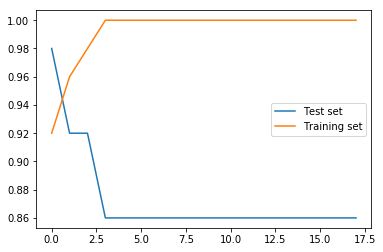

In [261]:
plt.plot(accuracy_test,label="Test set")
plt.plot(accuracy_train,label="Training set")
plt.legend()

After removing the GNI variable, we can see that the two accuracy curves remains really high even when increasing the number of neighbors. The accuracy score is much better than before.

# Classification - conclusion

Overall, the two algorithms were capable of classifying the countries into the 3 classes we made. It was easier for both of them to do so with the manually made labels, but for KNN the accuracy was nonetheless quite high with the labels created by the Kmeans clustering method. The Decision tree method couldn't really classify the countries whith those labels.
Although the correlation between the variables didn't seem to have an influence on the KNN mehtod, the decision tree algorithm was much more efficient once GNI was removed, even with Kmeans labels. Nonetheless, it appears that there is still an overfitting effect.